### Important note before we start:

- If you have access to Gadi and hh5 then you can run this notebook using one of the analysis conda environments. 

- Alternatively you can run this notebook using Google Colab, you just need to run the cell below:

In [ ]:
# Only use this on Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Overview

In this tutorial, we will use the **Atmospheric Rivers dataset** described in xxxx to train a Convolutional Neural Network (CNN) that can identify whether a map contains an atmospheric river or not. The script is written in Python and will perform three key tasks:

- **Load training data**: the training data consists of chips of Integrated Vapor Transport (IVT) maps and their corresponding labels ('Atmospheric River', 'Ambiguous', or empty if these two shapes are not present. We be begin by loading the data, and preparing it for input into our neural network.
- **Train a CNN**: using the TensorFlow and Keras libraries, we'll train a CNN to classify the IVT chips (images) into one of two predifined classes. Here, Class 1 is assigned to images containing an atmospheric river, and Class 0 is assigned to images not containing an atmospheric river or containing an ambiguous shape.
- **Evaluate model performance**: after training, we'll evaluate the model on data that was not used during training.

# Data

The data can be downloaded from https://doi.org/10.5281/zenodo.12177339

- **MAP_FILE_PATH**: Path to a text file containing the labels of IVT images.
- **IMAGES_PATH**: The directory containing the IVT images.

Note: Replace ```<<your Directory>>``` with the directory the data was saved to. If you are using Google Colab then replace ```<<your Directory>>``` with ```/content/drive/MyDrive```.

In [ ]:
# The Atmospheric Rivers dataset can be accessed through these links
MAP_FILE_PATH = "<<your Directory>>/Training_Testing_Tiles/RCNN_Masks_All_Tiles (no 3-10-15)/map.txt"
IMAGES_PATH = "<<your Directory>>/Training_Testing_Tiles/RCNN_Masks_All_Tiles (no 3-10-15)/images/" 

# Libraries

Here's a list of libraries required for this task:

- **re**: provides tools to handle regular expressions. It is used here to parse text files and extract the path and label of each image (IVT map chips)
- **matplotlib.pyplot**: provides plotting tools.
- **numpy**: used to store the data in arrays.
- **torchvision.models**: this module provides access to pre-trained models; however, in this tutorial, we'll use it to design a custom CNN model tailored specifically to our data.
- **tensorflow.keras.preprocessing.image**: provides tools to load the IVT map data and convert it into arrays.
- **tensorflow.keras**: a user-friendly API for building and training machine learning models. We use tools from this API to define the architecture of the CNN model and its training components.
- **sklearn.model_selection**: used to split the **Atmospheric Rivers dataset** into training set, validation set and test set.
- **sklearn.metrics**: provides performance metrics to evaluate the CNN model.
- **sklearn.utils.class_weight**: provides tools to help train models on datasets with imbalanced classes.


In [ ]:
# %% Libraries
import re
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight


These additional libraries and script are needed to ensure reproducibility of the results


In [3]:
import random
from tensorflow.random import set_seed
import os
# Set seeds for reproducibility
def set_seed_all(seed=42):
    # Set the seed for numpy's random number generator
    np.random.seed(seed)
    # Set the seed for TensorFlow's random number generator
    set_seed(seed)
    # Set the seed for Python hash-based operations
    os.environ['PYTHONHASHSEED'] = str(seed)

### Constants

- **IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS**: The dimensions of the IVT map chips or 'images'. Here, each image contains a single channel containing the IVT values on a given day. This is unlike RGB images, which contain 3 channels one for each colour.

In [4]:

# %% Constant
IMAGE_HEIGHT = 40
IMAGE_WIDTH = 32 # The original width of the image is 20 pixels, which is too small, so it will be resized to 32 pixels.
CHANNELS = 1

# Loading the Atmospheric Rivers dataset

We'll use an ImageDatasetLoader class to load the IVT images and their class labels, and store them in numpy arrays.
The dataset is then split into training, validation, and test sets using train_test_split. This separation helps in training the model on one subset of the data (training set), tuning the model's hyperparameters on another (validation set), and finally evaluating its performance on unseen data (test set).

In [5]:
# Define a class to load all the IVT images in the appropriate format.
class ImageDatasetLoader:
    # Initialize the class with paths and target size
    def __init__(
        self, map_file_path, images_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH)
    ):
        self.map_file_path = map_file_path
        self.images_path = images_path
        self.target_size = target_size

    # Load the training data
    def load_data(self):
        self._read_map_file()  # Read the text file that contains paths to IVT images and their class labels
        self._process_file_paths()  # Extract the paths of the images
        self.images = self._load_and_preprocess_images()  # Load and preprocess the images
        self.labels = self._extract_labels()  # Extract the labels
        return self.images, self.labels  # Return images and labels

    # Read the text file (map.txt) which contains paths to IVT images and their class labels
    def _read_map_file(self):
        try:
            with open(self.map_file_path, "r") as file:  # Open the map.txt file
                lines = file.readlines()  # Read the lines
            self.data = [self._process_line(line) for line in lines]  # Process each line
            # Filter out none entries
            self.data = [line for line in self.data if line is not None]
        except Exception as e:  # Handle exceptions
            raise Exception(f"Error reading file: {e}")

    # Process each line in the map file. Each line corresponds to a single image file.
    def _process_line(self, line):
        parts = re.split(r"\s+", line.strip(), maxsplit=1)  # Split the line into two parts, the first part contains the path and the second one contains the label
        if len(parts) == 1 or not parts[1]:  # If the second part is empty, this indicates that there is no atmospheric river or ambiguous shape present
            parts.append(0)  # Append 0, the class in this case should be '0'
        elif "Ambiguous" in parts[1]:  # If the line contains "Ambiguous", exclude the image
            return None
        elif "Atmospheric" in parts[1]:  # If the line contains "Atmospheric"
            parts[1] = 1  # The class is set to 1
        else:  # For other cases
            parts[1] = -1
            print(f"Unexpected string format: {parts}")  # Print a warning message
        return parts  # Return the labels of all the images

    # Update the file paths in self.data to point to the actual location of the images
    def _process_file_paths(self):
        self.data = np.array(self.data, dtype=object)
        # Replace the occurence of the substring "images\\" in each path with the value stored in 'self.images_path'
        self.data[:, 0] = [
            path.replace("images\\", self.images_path) for path in self.data[:, 0]
        ]

    # Load the images in a numpy array
    def _load_and_preprocess_images(self):
        images = [self._load_and_preprocess_image(path) for path in self.data[:, 0]]
        return np.array(images)  # Return the images as a numpy array

    # Load and preprocess an image
    def _load_and_preprocess_image(self, file_path):
        # Load each image from the given file path as a grayscale image.
        # The target_size=self.target_size parameter can be omitted if you do not want to change the size of the images.
        img = load_img(file_path, color_mode="grayscale", target_size=self.target_size)
        img_array = img_to_array(img) / 255.0  # Convert the image to an array and normalize it. Recall that a grayscale image has a value range between 0 and 255.
        return img_array  # Return the image data as an array

    # Extract the labels
    def _extract_labels(self):
        labels = self.data[:, 1].astype(int)
        return np.array(labels, dtype="int")  # Return the labels in a numpy array


In [7]:
set_seed_all(42) # To ensure reproducibility of the results

# Load and split dataset
loader = ImageDatasetLoader(MAP_FILE_PATH, IMAGES_PATH)
images, labels = loader.load_data()

# Count the number of images in each class, where '1' indicates the presence of an atmospheric river in the image, and '0' indicates its absence
_, counts = np.unique(labels, return_counts=True)
print(counts)

# First, split the data into a 'training' set and a 'validation + test' set
X_train, X_temp, y_train, y_temp = train_test_split(
    images, labels, test_size=0.3, stratify=labels #, random_state=42
) # X_train and y_train contain the feature images and labels of the training dataset, respectively.

# Then split the 'validation + test' set (i.e., X_temp, y_temp) into two separate sets: 'validation' and 'test'
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp #, random_state=42
)

[1846  452]


# Model Training

Although this tutorial does not explicitely show it, we first experimented with several different architectures and hyperparameters. We then chose the architecture and configuration that yield the best results on the validation set.   

## Architecture

Our CNN is built from these layers:

- **Conv2D Layer (64 filters, 2x2 kernel)**: This is the first convolutional layer. It has 32 filters, each with a 2x2 kernel size. The role of the convolutional layer is to detect features such as edges, colors, and textures in the input images. The relu (rectified linear unit) activation function is used here to introduce non-linearity to the model, helping it learn more complex patterns.
- **MaxPooling2D Layer (2x2 pool size)**: This pooling layer reduces the spatial dimensions (height and width) of the input volume. It does this by taking the maximum value over a 2x2 pooling window. Pooling helps make the detection of features somewhat invariant to scale and orientation changes and reduces the computational load.

- **Conv2D Layer (64 filters, 3x3 kernel)**: This is the second convolutional layer. It has 64 filters, each with a 3x3 kernel size. This layer can detect more complex features built from the simpler features identified in the previous layers.
- **MaxPooling2D Layer (2x2 pool size)**: This layer further reduces the spatial dimensions of the input volume.

- **Flatten Layer**: This layer flattens the 3D output of the previous convolutional and pooling layers into a 1D array. It's necessary because the following dense (fully connected) layers require 1D input.
- **Dense Layer (64 units)**: A fully connected layer that takes all the output from the previous layer and connects them to every single neuron in this layer.
- **Dense Layer (1 unit)**: The final layer in the network outputs a single neuron with a sigmoid activation function, which is appropriate for binary classification. This function squashes the output between 0 and 1, which is useful for predicting probabilities in binary outcomes, which is here the presence or absence of an atmospheric river in an image.

## Compilation

This step involves configuring the model for training by specifying its hyperparameters:

- **Optimizer**: adam, an optimisation algorithm commonly used in image processing tasks (e.g. image classification).
- **Loss function**: binary_crossentropy, which is suitable for binary classification problems.
- **Metrics**: accuracy.


In [36]:
# To ensure reproducibility of the results
set_seed_all(42)

# Define the architecture of the model
model = models.Sequential(
    [
        # First convolutional layer with 64 filters and 2x2 kernel size
        layers.Conv2D( 64, (2, 2), activation="relu",
            input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS),  # Input shape
        ),
        # First max pooling layer with 2x2 pool size
        layers.MaxPooling2D((2, 2)),

        # Second convolutional layer with 64 filters and 3x3 kernel size
        layers.Conv2D(64, (3, 3), activation="relu"),
        # Second max pooling layer with 2x2 pool size
        layers.MaxPooling2D((2, 2)),

        # Convert the 3D feature maps to 1D feature vectors
        layers.Flatten(),
        # Fully connected layer with 64 neurons
        layers.Dense(64, activation="relu"),
        # Output layer with 1 unit and sigmoid activation function for binary classification
        layers.Dense(1, activation="sigmoid"),
    ]
)

# Compile the model with Adam optimizer, binary crossentropy loss function, and accuracy metric
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Compute class weights. Useful for training on datasets with imbalanced classes. Here, "Atmospheric River", i.e. class 1 is underrepresented in the dataset.
classes = np.unique(y_train)  # Get unique classes
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)  # Compute class weights
class_weight_dict = {classes[i]: weights[i] for i in range(len(classes))}  # Create a dictionary that maps each class to its weight.

# Fit the model to the training data
# This scripts returns a History object, which contains information about the training process, including the loss and accuracy values for each epoch, and the validation metric.
cnn_AR = model.fit(
    X_train,  # Training features
    y_train,  # Training labels
    epochs=20,  # Number of epochs. An epoch is a single pass through the entire training dataset.
    validation_data=(X_val, y_val),  # Validation data
    class_weight=class_weight_dict,  # Class weights.
)

Epoch 1/20
51/51 [==============================] - 7s 110ms/step - loss: 0.6634 - accuracy: 0.4602 - val_loss: 0.7665 - val_accuracy: 0.4174
Epoch 2/20
51/51 [==============================] - 3s 69ms/step - loss: 0.6359 - accuracy: 0.5292 - val_loss: 0.6316 - val_accuracy: 0.4348
Epoch 3/20
51/51 [==============================] - 3s 66ms/step - loss: 0.6219 - accuracy: 0.4409 - val_loss: 0.6644 - val_accuracy: 0.4116
Epoch 4/20
51/51 [==============================] - 4s 79ms/step - loss: 0.6197 - accuracy: 0.4988 - val_loss: 0.6685 - val_accuracy: 0.3913
Epoch 5/20
51/51 [==============================] - 5s 99ms/step - loss: 0.6086 - accuracy: 0.4465 - val_loss: 0.7030 - val_accuracy: 0.4145
Epoch 6/20
51/51 [==============================] - 3s 66ms/step - loss: 0.6216 - accuracy: 0.4832 - val_loss: 0.6143 - val_accuracy: 0.4609
Epoch 7/20
51/51 [==============================] - 3s 67ms/step - loss: 0.6080 - accuracy: 0.5330 - val_loss: 0.5743 - val_accuracy: 0.7391
Epoch 8/20
5

# Model Evaluation

After training the CNN, the next important step is to evaluate its performance. We'll do this in three ways:

1.   Plot the evolution of accuracy relative to the number of epochs for both the validation set and training set.
2.   Visualise the model's performance on the test set using a confusion matrix.
3.   Calculate a range of performance metrics on the test set (Accuracy, Balanced Accuracy, True Positive Rate, True Negative Rate, and False Alarm Rate). Note that the positive class is '1'.



### 1) Plot the evolution of accuracy relative to the epoch for both the training and validation sets.

The plot provides insights into:
* *Model training progress:* how well the modell is learning over time
* *Overfitting/Underfitting:* whether the model is overfitting to the training data or underfitting both training and validation
* *Convergence:* whether further training does not significantly improve the model's performance.

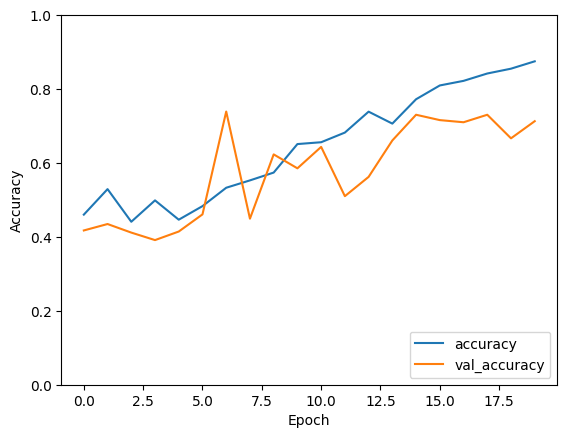

In [37]:
# Plot the training history
plt.plot(cnn_AR.history["accuracy"], label="accuracy")  # Plot the accuracy of the model for each epoch on the training data
plt.plot(cnn_AR.history["val_accuracy"], label="val_accuracy")  # Plot the accuracy of the model for each epoch on the validation data
plt.xlabel("Epoch")  # Label the x-axis
plt.ylabel("Accuracy")  # Label the y-axis
plt.ylim([0, 1])  # Set the limits of the y-axis
plt.legend(loc="lower right")  # Place a legend on the lower right side of the plot
plt.show()  # Display the plot

We infer from the Accuracy versus Epoch plot the following:


*   *Model Training Progress:* The training accuracy (blue line) shows a steady increase over epochs, indicating that the model is learning and improving its performance on the training data.
*   *Overfitting/Underfitting:* The validation accuracy (orange line) also increases but begins to plateau or decrease after 13 epochs, while the training accuracy is still increasing. This indicates that the model might be starting to overfit to the training data, especially after around 13 epochs.
*   *Convergence:* The training accuracy continues to increase and does not show clear signs of converging within the 20 epochs. The validation accuracy, however, seems to fluctuate without a consistent upward trend after a certain point, suggesting that further training might not significantly improve performance on the validation set and could potentially lead to some overfitting. This variability (or fluctuation) could be due to several factors, including the model's sensitivity to the specific validation data or its hyperparameters


### 2) Visualise the model's performance on the test set using a confusion matrix.

11/11 [==============================] - 0s 17ms/step


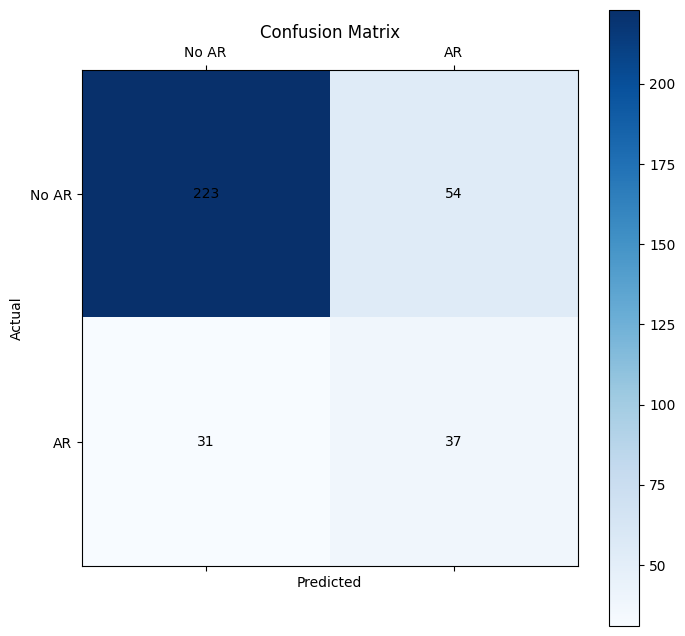

In [38]:
# %% Predict the labels for the test set
y_pred = model.predict(X_test)

# Convert the predicted probabilities to class labels (0 or 1)
y_pred_classes = np.round(y_pred).astype(int).reshape(-1)

# Calculate the confusion matrix using the true labels and the predicted labels
cm = confusion_matrix(y_test, y_pred_classes)


# Create a new figure and axes for the plot
fig, ax = plt.subplots(figsize=(8, 8))

# Display the confusion matrix as an image in the axes
cax = ax.matshow(cm, cmap="Blues")

# Add a color bar to the plot
plt.colorbar(cax)

# Set tick positions and labels for the x-axis and y-axis
ax.set_xticks([0, 1])
ax.set_xticklabels(["No AR", "AR"])
ax.set_yticks([0, 1])
ax.set_yticklabels(["No AR", "AR"])

# Add the confusion matrix values as text in the center of the cells
for (i, j), value in np.ndenumerate(cm):
    ax.text(j, i, f"{value}", ha="center", va="center", color="black")

# Set the labels for the x-axis and y-axis
plt.ylabel("Actual")
plt.xlabel("Predicted")

# Set the title for the plot
plt.title("Confusion Matrix")

# Display the plot
plt.show()

3) Calculate performance metrics on the test set

In [39]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_classes)
balanced_acc = balanced_accuracy_score(y_test, y_pred_classes)

# Calculate confusion matrix values
tn, fp, fn, tp = cm.ravel()

# Calculate additional rates
tpr = tp / (tp + fn)  # True Positive Rate
tnr = tn / (tn + fp)  # True Negative Rate
far = fp / (fp + tn)  # False Alarm Rate = 1 - True Negative Rate

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"True Positive Rate (TPR): {tpr:.4f}")
print(f"True Negative Rate (TNR): {tnr:.4f}")
print(f"False Alarm Rate (FAR): {far:.4f}")




Accuracy: 0.7536
Balanced Accuracy: 0.6746
True Positive Rate (TPR): 0.5441
True Negative Rate (TNR): 0.8051
False Alarm Rate (FAR): 0.1949


## Further Steps

There's always room for improvement. Here are some suggested steps to enhance the model's performance:

- **Hyperparameter Tuning**: Experimenting with different learning rates, batch sizes, or epochs can provide improvements. Tools like Keras Tuner or Hyperopt can automate this process by searching through a range of values to find the most effective settings.
- **Try Different Architectures**: While the current model uses a relatively simple architecture, exploring more complex or different architectures could yield better results. Consider architectures like ResNet, Inception, or custom architectures that might capture more complex patterns in the data.
- **Implement Dropout and Regularization**: If signs of overfitting become more pronounced with additional training, implementing regularization techniques such as dropout or L2 regularization might help.

---


**Authors**


*   **Maher Mesto**, AI Academic
    
    *School of Computer Science and Engineering, UNSW Sydney*
    
    m.mesto@unsw.edu.au

*   **Sanaa Hobeichi**, Postdoctoral Researcher in Climate & AI

    *Centre of Excellence for Climate Extremes & Climate Change Research Centre, UNSW Sydney*
    
    s.hobeichi@unsw.edu.au

*   **Samuel Green**, Computational Modelling Specialist

    *Centre of Excellence for Climate Extremes & Climate Change Research Centre, UNSW Sydney*

    sam.green@unsw.edu.au
